In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from model import C2F_TCN
from dataset import AugmentDataset, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='3'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=50,
    learning_rate=1e-4,
    weight_decay=3e-3,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=10,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-full-length-timestamp/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 50, 'learning_rate': 0.0001, 'weight_decay': 0.003, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 10, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-full-length-timestamp/', 'project_name': 'breakfast-split-2', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_sup

In [7]:
traindataset = AugmentDataset(config, fold='train', fold_file_name=config.train_split_file, augment=False)
testdataset = AugmentDataset(config, fold='test', fold_file_name=config.test_split_file, augment=False)

Number of videos logged in train fold is 1261
Number of videos not found in train fold is 0
Number of videos logged in test fold is 451
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [31]:
loaded_vidid_selected_frames = pickle.load(open("dump_dir/selected_frames_timestamp_paper.pkl", "rb"))
for key in loaded_vidid_selected_frames.keys():
    value = loaded_vidid_selected_frames[key]
    new_val_list = [value[0]]
    for i, v in enumerate(value[1:]):
        v_p = value[i]
        if v_p == v:
            new_val_list.append(v+1)
        else:
            new_val_list.append(v)
    loaded_vidid_selected_frames[key] = new_val_list
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/breakfast_split2_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [46]:
loaded_vidid_selected_frames

{'P26_cam02_P26_scrambledegg.txt': [0,
  1,
  72,
  101,
  127,
  159,
  193,
  230,
  294,
  336],
 'P44_webcam01_P44_salat.txt': [3, 10, 76, 223, 273, 332, 489],
 'P53_webcam02_P53_cereals.txt': [0, 23, 33, 60, 84],
 'P21_webcam02_P21_coffee.txt': [0, 17, 26],
 'P15_cam01_P15_scrambledegg.txt': [0, 1, 23, 112, 150, 160, 171],
 'P17_cam01_P17_tea.txt': [1, 19, 52, 61],
 'P45_webcam01_P45_sandwich.txt': [1, 48, 80, 90, 96],
 'P51_cam02_P51_salat.txt': [0, 2, 48, 104, 122, 203, 226, 266, 318, 331, 340],
 'P51_cam01_P51_scrambledegg.txt': [3,
  23,
  72,
  91,
  137,
  157,
  182,
  205,
  253,
  297,
  337,
  339],
 'P43_cam02_P43_juice.txt': [1, 8, 118, 149, 161],
 'P24_cam01_P24_milk.txt': [3, 10, 19, 57, 80, 98, 100, 139],
 'P09_cam01_P09_friedegg.txt': [0, 3, 43, 75, 127, 140, 166, 236],
 'P05_cam01_P05_coffee.txt': [0, 5, 31, 43, 96, 105],
 'P25_webcam02_P25_pancake.txt': [0,
  4,
  25,
  31,
  63,
  101,
  117,
  171,
  217,
  262,
  468,
  495,
  514,
  520],
 'P23_webcam01_P23_c

In [32]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class, min_len):
    mean_class, std_class = loaded_mean_var_actions[cur_class]   
    prob = (cur_len * np.log(mean_class + 1e-5))
    prob = prob - mean_class
    prob = prob - np.sum(np.log(np.arange(1, cur_len, 1)))
    return prob

get_possion_prob(20, 20, 10)

0.48488744950308416

In [33]:
prob_video_each_segment_dict = {}

In [34]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):
        
        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]
        prob_list = []
        for ele in range(cur_ele, next_ele, 1):
            start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
            sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
            sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
            
            len_cur_class = ele - cur_boundary
            len_prob = get_possion_prob(len_cur_class, label_cur_ele.item(), cur_ele)
            prob_list.append((sum_window_class_1 + sum_window_class_2) + len_prob.item())
        
        if len(prob_list) == 0:
            import pdb
            pdb.set_trace()
        prob_list = torch.softmax(torch.stack(prob_list), dim=0)
        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob_list.detach().cpu().numpy()).item())
        prob_each_segment.append(prob_list)
    
    return prob_each_segment

In [35]:
# selected_frames = torch.tensor([2, 10, 17, 21])
# cur_vid_feat = torch.randn((27, 48))
# labels = torch.tensor([47, 47, 47, 47, 47, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10])
# # print(len(labels))
# probs_all_segs = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
# print(probs_all_segs)

In [36]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        if len(selected_frames) == 0:
            import pdb
            pdb.set_trace()
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [37]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob)
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            count = 0
            for ele in range(cur_ele, next_ele, 1):
                start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
                sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
                sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
                current_vid_prob_arr.append((sum_window_class_1 + sum_window_class_2)  * (prob_each_video[i][count].item()))
                count = count + 1
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob)
            
        loss_arr.append(torch.stack(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr
#     return loss_arr

In [38]:
def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele + ".txt"]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [44]:
def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            import pdb
            pdb.set_trace()
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")


In [45]:
get_boundary_err()

> <ipython-input-44-3bed25ed5369>(17)get_boundary_err()
-> print(ele)
(Pdb) estimated
array([ 6, 16, 41, 62, 96])
(Pdb) actual
array([11, 35, 47, 90])
(Pdb) loaded_vidid_selected_frames[ele+".txt"]
[0, 8, 34, 50, 83, 100]
(Pdb) loaded_vidid_selected_frames["P37_webcam02_P37_scrambledegg.txt"]
[0, 7, 40, 47, 87, 115, 134]
(Pdb) video_id_boundary_frames[ele]
[11, 35, 47, 90, 103]
(Pdb) loaded_vidid_selected_frames["P53_cam01_P53_friedegg.txt"]
[0, 1, 36, 79, 90, 119, 191]
(Pdb) q


BdbQuit: 

In [40]:
def get_validation_acc(model):
    model.eval()
    print("Calculating Validation Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item[0] = item[0].to(device)
            item[1] = item[1].to(device)
            item[2] = item[2].to(device)
            y, _, features = model(item[0].permute(0,2,1))
            prob = torch.softmax(y, dim=1).permute(0,2,1)

            src_mask = torch.arange(item[2].shape[1], device=item[2].device)[None, :] < item[1][:, None]
            pred = torch.argmax(prob, dim=2)
            correct += float(torch.sum((pred == item[2]) * src_mask).item())
            total += float(torch.sum(src_mask).item())
    val_acc = correct * 100.0 / total
    print(f"Validation Accuracy calculated with model probabilities {val_acc: .3f}")
    return val_acc

In [41]:
set_seed()
model = C2F_TCN(n_channels=config.feature_size, n_classes=config.num_class).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-3)

# Requires loaded_vidid_selected_frames, boundaries_dict
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [42]:
val_acc_arr = []
for epoch in range(2000):
    if epoch % 5 == 0:
        model.eval()
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0
        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item[0] = item[0].to(device)
                item[1] = item[1].to(device)
                item[2] = item[2].to(device)
                y, _, features = model(item[0].permute(0,2,1))
                prob = torch.softmax(y, dim=1)
                prob = prob.permute(0,2,1)
                calculate_element_probb(prob, item[1], item[5], item[2])
                
                src_mask = torch.arange(item[2].shape[1], device=item[2].device)[None, :] < item[1][:, None]
                pred = torch.argmax(prob, dim=2)
                correct += float(torch.sum((pred == item[2]) * src_mask).item())
                total += float(torch.sum(src_mask).item())
        print(f"Epoch {epoch} Train Accuracy calculated with probabilities {correct * 100.0 / total: .3f}")
        get_boundary_err()
        
        val_acc = get_validation_acc(model)
        val_acc_arr.append(val_acc)
        val_acc_arr.sort()
        print(f"Epoch {epoch} " + "Best 3 val accuracy till now = ", val_acc_arr[-3:])

    model.train()
    print("Starting Maximization")
    for i, item in enumerate(trainloader):
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        
        optimizer.zero_grad()
        y, _, features = model(item[0].permute(0,2,1))
        prob = torch.softmax(y, dim=1)
        prob = prob.permute(0,2,1)
        loss, _ = get_estimated_loss(prob, item[1], item[5], item[2].to(device))
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"Epoch {epoch} iteration {i} Current loss {loss.item()}")

Calculating Expectation


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch 0 Train Accuracy calculated with probabilities  4.757
P50_stereo01_P50_tea
P53_cam02_P53_pancake
P11_webcam01_P11_pancake
P06_cam01_P06_pancake
P48_cam01_P48_scrambledegg
P47_webcam02_P47_scrambledegg
P39_webcam01_P39_pancake
P04_cam01_P04_friedegg
P50_webcam01_P50_tea
P14_stereo01_P14_coffee
P53_webcam01_P53_pancake
P13_stereo01_P13_scrambledegg
P04_webcam02_P04_scrambledegg
P15_cam01_P15_scrambledegg
P12_webcam01_P12_cereals
P36_stereo01_P36_coffee
P53_cam02_P53_friedegg
P38_webcam01_P38_coffee
P15_webcam01_P15_friedegg
P33_cam02_P33_pancake
P15_webcam01_P15_milk
P54_cam02_P54_scrambledegg
P14_stereo01_P14_friedegg
P34_webcam02_P34_scrambledegg
P15_stereo01_P15_friedegg
P42_stereo01_P42_scrambledegg
P08_webcam01_P08_coffee
P36_webcam02_P36_friedegg
P12_webcam01_P12_pancake
P38_webcam02_P38_friedegg
P13_webcam01_P13_scrambledegg
P40_webcam02_P40_pancake
P42_cam02_P42_pancake
P37_webcam02_P37_coffee
P29_cam02_P29_coffee
P47_cam01_P47_friedegg
P37_webcam01_P37_coffee
P54_webcam02_

/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Validation Accuracy calculated with model probabilities  4.401
Epoch 0 Best 3 val accuracy till now =  [4.400578751550228]
Starting Maximization
Epoch 0 iteration 0 Current loss 4.643324851989746
Epoch 0 iteration 10 Current loss 3.5544896125793457
Epoch 0 iteration 20 Current loss 3.206502914428711


KeyboardInterrupt: 

In [10]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [11]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [12]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

In [13]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [14]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele + ".txt"]):
        print(ele)

In [15]:
"""
loaded_vidid_selected_frames = pickle.load(open("dump_dir/breakfast_split2_selected_frames_dict.pkl", "rb"))
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/breakfast_split2_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames
"""
# import pickle
# pickle.dump(video_id_boundary_frames, open("dump_dir/breakfast_split2_selected_frames_dict.pkl", "wb"))
# pickle.dump(loaded_vidid_selected_frames, open("dump_dir/breakfast_split2_boundary_frames_dict.pkl", "wb"))

In [55]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [56]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

<All keys matched successfully>

In [21]:
model.eval()
loss_arr = []
correct = 0.0
total = 0.0
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        y, y_list, _ = model(item[0].permute(0,2,1))
        prob = torch.softmax(y, dim=1).permute(0,2,1)
#         prob = get_ensemble_out([y, y_list]).permute(0,2,1)
        calculate_element_probb(prob, item[1], item[5], item[2].to(device))
        loss, _ = get_estimated_loss(prob, item[1], item[5], item[2].to(device))
        loss_arr.append(loss)
        
        estimated_labels = torch.argmax(prob, dim=2)
        correct += torch.sum(estimated_labels == )
#         probs = get_ensemble_out([y, y_list])
#         features = torch.log(probs + 1e-4).permute(0,2,1)
#         get_estimated_boundary(features, item[1], item[5])
get_boundary_err()
print("Average loss", torch.mean(torch.tensor(loss_arr)))

Boundary avergage error = 25.242
From boundary avergage accuracy = 69.543
tensor(0.4019)


In [22]:
for i in range(prob.shape[0]):
    loss_i, _ = get_estimated_loss(prob[i].unsqueeze(0), item[1][i].unsqueeze(0), [item[5][i]], item[2][i].unsqueeze(0))
    print(loss_i)
#     print(torch.mean(torch.cat(loss_i)))

tensor(0.4542, device='cuda:0')
tensor(0.1349, device='cuda:0')
tensor(1.5728, device='cuda:0')
tensor(0.6470, device='cuda:0')
tensor(0.2702, device='cuda:0')
tensor(0.5915, device='cuda:0')
tensor(2.8901, device='cuda:0')


In [65]:
loss_i

tensor(0.7432, device='cuda:0')

In [28]:
with torch.no_grad():
    idx = 6

    cur_vid_feat = prob[idx]
    cur_vidid = item[5][idx]
    labels = item[2][idx]
    selected_frames = torch.tensor(loaded_vidid_selected_frames[cur_vidid + ".txt"], dtype=torch.long, 
                                   device=cur_vid_feat.device)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)

In [29]:
loss_i, _ = get_estimated_loss(prob[idx].unsqueeze(0), item[1][idx].unsqueeze(0), [item[5][idx]], item[2][idx].unsqueeze(0))

In [30]:
loss_i

tensor(2.8901, device='cuda:0')

(0, 1.2)

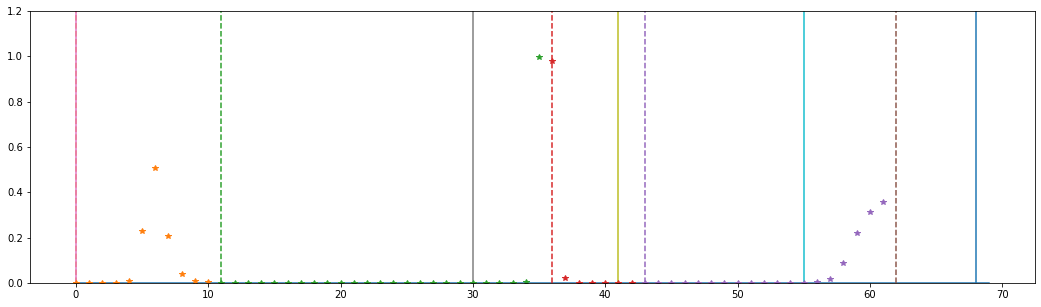

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1.2

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
#     all_prob.append(segment/torch.sum(segment))
    prob_i = segment / torch.sum(segment)
    prob_i = prob_i.cpu().numpy()
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid + ".txt"][i], loaded_vidid_selected_frames[cur_vidid + ".txt"][i+1])
    plt.plot(xs, prob_i, '*')

plt.ylim([0, ymax])
# all_prob = torch.cat(all_prob).cpu().numpy()
# xs = np.arange(loaded_vidid_selected_frames[cur_vidid][0] + 1, loaded_vidid_selected_frames[cur_vidid][-1])
# plt.plot(xs, all_prob, '-')

In [80]:
cur_vid_feat = torch.softmax(y, dim=1).permute(0,2,1)[idx]
cur_vid_count = item[1][idx]
labels = item[2][idx]

selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
prob_each_video = prob_video_each_segment_dict[cur_vidid]

log_probs = torch.log(cur_vid_feat + 1e-8)
cumsum_feat = torch.cumsum(log_probs, dim=0)

full_arr = []
for i, cur_ele in enumerate(selected_frames[:-1]):
    next_ele = selected_frames[i + 1]
    label_cur_ele = labels[cur_ele]
    label_next_ele = labels[next_ele]
    prob_list = [] 

    count = 0
    for ele in range(cur_ele, next_ele, 1):
        start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
        sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
        sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
        prob_list.append((sum_window_class_1 + sum_window_class_2)  * (prob_each_video[i][count].item()))
        count = count + 1
    full_arr.append(torch.stack(prob_list))

In [81]:
-torch.mean(torch.cat(full_arr))

tensor(0.3756, device='cuda:0')

In [83]:
label_cur_ele

tensor(14)

In [84]:
label_next_ele

tensor(47)

In [85]:
selected_frames

[0, 10, 18, 60, 102, 183, 198, 242]

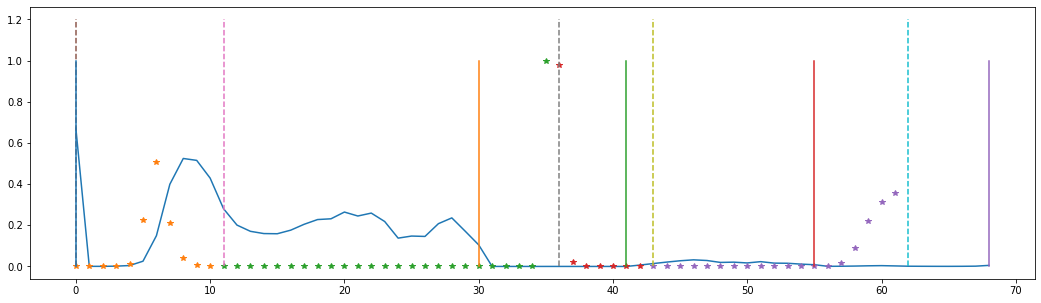

In [32]:
plt_arr = []


for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

all_prob = []
for i, segment in enumerate(prob_each_segment):
#     all_prob.append(segment/torch.sum(segment))
    prob_i = segment / torch.sum(segment)
    prob_i = prob_i.cpu().numpy()
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid + ".txt"][i], 
                   loaded_vidid_selected_frames[cur_vidid + ".txt"][i+1])
    plt.plot(xs, prob_i, '*')

for pivot in loaded_vidid_selected_frames[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 1])

In [51]:
given_video_selec_frames = pickle.load(open("dump_dir/selected_frames_timestamp_paper.pkl", "rb"))
ours_video_selec_frames = pickle.load(open("dump_dir/breakfast_split2_selected_frames_dict.pkl", "rb"))
diff_count = 0
for key in ours_video_selec_frames.keys():
    value_ours = ours_video_selec_frames[key]
    value_there = given_video_selec_frames[key + ".txt"]
    if len(value_ours) != len(value_there):
        gr_file_list = open(config.ground_truth_files_dir + "/" + key + '.txt').read().split("\n")[0:-1]
        gr_file_list_short = np.array(gr_file_list[::10])
        print("Ground truth unique values = ", np.unique(gr_file))
        print("There values = ", gr_file_list_short[value_there])
        print(" Our values = ", gr_file_list_short[value_ours])
        print("Given selected len = ", len(value_there))
        print("Our slected len = ", len(value_ours))
        diff_count += len(value_there) -len(value_ours)
    else:
        print("IT IS SAME")

IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'pour_oil' 'crack_egg' 'add_saltnpepper' 'fry_egg' 'fry_egg' 'SIL']
 Our values =  ['pour_oil' 'crack_egg' 'add_saltnpepper' 'fry_egg' 'put_egg2plate' 'SIL']
Given selected len =  7
Our slected len =  6
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'crack_egg' 'spoon_flour' 'pour_milk' 'stir_dough' 'butter_pan'
 'pour_dough2pan' 'fry_pancake' 'take_plate' 'put_pancake2plate' 'SIL']
 Our values =  ['crack_egg' 'spoon_flour' 'pour_milk' 'stir_dough' 'butter_pan'
 'pour_dough2pan' 'fry_pancake' 'take_plate' 'put_pancake2plate' 'SIL']
Given selected len = 

Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'take_bowl' 'crack_egg' 'spoon_flour' 'pour_milk' 'stir_dough'
 'pour_oil' 'pour_dough2pan' 'fry_pancake' 'take_plate'
 'put_pancake2plate' 'SIL']
 Our values =  ['take_bowl' 'crack_egg' 'spoon_flour' 'pour_milk' 'stir_dough' 'pour_oil'
 'pour_dough2pan' 'fry_pancake' 'take_plate' 'put_pancake2plate' 'SIL']
Given selected len =  12
Our slected len =  11
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'SIL' 'pour_milk' 'spoon_flour' 'stir_dough' 'pour_milk'
 'stir_dough' 'pour_milk' 'stir_dough' 'pour_oil' 'stir_dough'
 'pour_dough2pan' 'fry_pancake' 'pour_oil' 'fry_pancake' 'take_plate'
 'put_pancake2plate' 'SIL']
 Our values =  

Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'crack_egg' 'spoon_flour' 'pour_milk' 'stir_dough' 'butter_pan'
 'stir_dough' 'pour_dough2pan' 'take_plate' 'fry_pancake'
 'put_pancake2plate' 'SIL']
 Our values =  ['crack_egg' 'spoon_flour' 'pour_milk' 'stir_dough' 'butter_pan'
 'stir_dough' 'pour_dough2pan' 'take_plate' 'fry_pancake'
 'put_pancake2plate' 'SIL']
Given selected len =  12
Our slected len =  11
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'spoon_flour' 'pour_milk' 'crack_egg' 'stir_dough' 'butter_pan'
 'pour_dough2pan' 'fry_pancake' 'take_plate' 'take_plate'
 'put_pancake2plate']
 Our 

IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'pour_coffee' 'pour_milk']
 Our values =  ['pour_coffee' 'pour_milk']
Given selected len =  3
Our slected len =  2
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'spoon_flour' 'pour_milk' 'crack_egg' 'stir_dough' 'butter_pan'
 'pour_dough2pan' 'fry_pancake' 'take_plate' 'put_pancake2plate' 'SIL']
 Our values =  ['spoon_flour' 'pour_milk' 'crack_egg' 'stir_dough' 'butter_pan'
 'pour_dough2pan' 'fry_pancake' 'take_plate' 'put_pancake2plate' 'SIL']
Given selected len =  11
Our slected len =  10
IT IS S

There values =  ['SIL' 'take_cup' 'add_teabag' 'pour_water' 'spoon_sugar' 'SIL']
 Our values =  ['take_cup' 'add_teabag' 'pour_water' 'spoon_sugar' 'SIL']
Given selected len =  6
Our slected len =  5
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'pour_coffee' 'spoon_sugar' 'pour_milk' 'SIL']
 Our values =  ['pour_coffee' 'spoon_sugar' 'pour_milk' 'SIL']
Given selected len =  5
Our slected len =  4
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'pour_oil' 'crack_egg' 'stir_egg' 'pour_egg2pan' 'stirfry_egg'
 'add_saltnpepper

Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'butter_pan' 'crack_egg' 'stirfry_egg' 'add_saltnpepper'
 'stirfry_egg' 'take_plate' 'put_egg2plate' 'put_egg2plate']
 Our values =  ['butter_pan' 'crack_egg' 'stirfry_egg' 'add_saltnpepper' 'stirfry_egg'
 'take_plate' 'put_egg2plate' 'SIL']
Given selected len =  9
Our slected len =  8
IT IS SAME
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'pour_coffee' 'spoon_sugar' 'pour_milk' 'SIL']
 Our values =  ['pour_coffee' 'spoon_sugar' 'pour_milk' 'SIL']
Given selected len =  5
Our slected len =  4
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT I

Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'pour_coffee' 'spoon_sugar' 'pour_milk' 'SIL']
 Our values =  ['pour_coffee' 'spoon_sugar' 'pour_milk' 'SIL']
Given selected len =  5
Our slected len =  4
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'crack_egg' 'stir_egg' 'butter_pan' 'add_saltnpepper' 'stir_egg'
 'pour_egg2pan' 'stirfry_egg' 'take_plate' 'put_egg2plate' 'put_egg2plate']
 Our values =  ['crack_egg' 'stir_egg' 'butter_pan' 'add_saltnpepper' 'stir_egg'
 'pour_egg2pan' 'stirfry_egg' 'take_plate' 'put_egg2plate' 'SIL']
Given selected len =  11
Our slected len =  10
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_mi

Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'take_cup' 'add_teabag' 'pour_water' 'spoon_sugar' 'spoon_sugar']
 Our values =  ['take_cup' 'add_teabag' 'pour_water' 'spoon_sugar' 'SIL']
Given selected len =  6
Our slected len =  5
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'crack_egg' 'spoon_flour' 'pour_milk' 'stir_dough' 'butter_pan'
 'pour_dough2pan' 'fry_pancake' 'take_plate' 'put_pancake2plate' 'SIL']
 Our values =  ['crack_egg' 'spoon_flour' 'pour_milk' 'stir_dough' 'butter_pan'
 'pour_dough2pan' 'fry_pancake' 'take_plate' 'put_pancake2plate' 'SIL']
Given selected le

Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'crack_egg' 'add_saltnpepper' 'stir_egg' 'butter_pan' 'take_plate'
 'pour_egg2pan' 'stirfry_egg' 'put_egg2plate' 'put_egg2plate']
 Our values =  ['crack_egg' 'add_saltnpepper' 'stir_egg' 'butter_pan' 'take_plate'
 'pour_egg2pan' 'stirfry_egg' 'put_egg2plate' 'SIL']
Given selected len =  10
Our slected len =  9
IT IS SAME
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'crack_egg' 'add_saltnpepper' 'stir_egg' 'pour_oil' 'pour_egg2pan'
 'stirfry_egg' 'stirfry_egg' 'SIL']
 Our values =  ['crack_egg' 'add_saltnpepper' 'stir_egg' 'pour_oil' 'pour_egg2pan'
 'stirfry_egg' 'put_egg2plate' 'SIL']
Given selected len =  9
Our slected len = 

Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'crack_egg' 'add_saltnpepper' 'stir_egg' 'butter_pan' 'take_plate'
 'pour_egg2pan' 'stirfry_egg' 'put_egg2plate' 'SIL']
 Our values =  ['crack_egg' 'add_saltnpepper' 'stir_egg' 'butter_pan' 'take_plate'
 'pour_egg2pan' 'stirfry_egg' 'put_egg2plate' 'SIL']
Given selected len =  10
Our slected len =  9
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
IT IS SAME
Ground truth unique values =  ['SIL' 'crack_egg' 'fry_pancake' 'pour_dough2pan' 'pour_milk' 'pour_oil'
 'put_pancake2plate' 'spoon_flour' 'stir_dough' 'take_bowl' 'take_plate']
There values =  ['SIL' 'take_bowl' 'crack_egg' 'spoon_flour' 'pour_milk' 'stir_dough'
 'pour_oil' 'pour_dough2pan' 'fry_pancake' 'take_plate'
 'put_pancake2plate' 'SIL']
 Our values =  ['take_bowl' 'crack_egg' 'spoon_flour' 'pour_milk' 'stir_do